# *refellips* 
### Example: 55 nm thick Au thin film at 65°

Based on the [official refellips demos](https://refellips.readthedocs.io/en/main/examples.html)

### Packages needed to do the fitting

In [1]:
from pprint import pprint # To see de attributes of the objects defined on refellips

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import refellips
from refellips.dataSE import DataSE
from refellips.reflect_modelSE import ReflectModelSE
from refellips.objectiveSE import ObjectiveSE
from refellips.dispersion import RI
from refellips import load_material

In [4]:
import refnx
from refnx.analysis import CurveFitter

In [5]:
print(
    f"refellips: {refellips.version.version}\nrefnx: {refnx.version.version}\nnumpy: {np.version.version}"
)

refellips: 0.0.6
refnx: 0.1.60
numpy: 2.3.3


## Import raw data from a CSV fiile: (wavelength , angle of incidence, psi, delta)

The data used in this example was calculated with the transfere matrix method found in the [Optics_Plane_Interface.wls](https://github.com/jaurrutia/Wolfram_scripts) written in Wolfram Language.

Sistem:
- Air $n=1$
- 55 nm Gold thin film (Johnson & Christy)
- Glass $n=1.5$
- $\theta_i = 65^\circ$ (External incidence)

In [6]:
file = "Bk7Au.csv" # CSV: wavelength, aoi, psi, delta
data = DataSE(data=file, delimiter = ",") # Commas separated values (CSV) file
                                          # Specific data can be recovred with the following flags: .data, .wavelenght, .aoi, .psi, .delta
                                          # More: https://refellips.readthedocs.io/en/main/refellips.dataSE.html

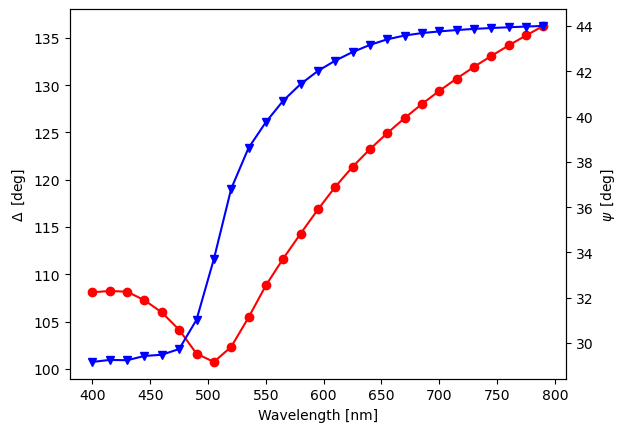

In [7]:
fig, ax = plt.subplots() 
axt = ax.twinx()

ax.plot(data.wavelength, data.delta, ls = '-', color = 'r', marker = "o")
axt.plot(data.wavelength, data.psi, ls = '-', color = 'b', marker = "v")
ax.set(ylabel=r'$\Delta\,$ [deg]', xlabel=r"Wavelength [nm]")
axt.set(ylabel=r"$\psi\,$ [deg]");

## Building the stratified systems

To build the multilayer system, information on the refractive index  $n$ of the materials is needed. This is given by the object: [refellips.dispersion()](https://refellips.readthedocs.io/en/main/refellips.dispersion.html)

#### Dispersion models 
- Several disperssion models are defined in *refellips* 
- Depending on the employed model, the parameters are represented in different units.
- To expand the library on disperssion models include them in `$VENV/lib/python3.13/site-packages/refellips/dispersion.py`
- [Example from documentation](https://nbviewer.org/github/refnx/refellips/blob/main/demos/refellipsDemo_UserDefinedOscillator.ipynb)

#### Experimental data
- Avialable with the function `load_material()`, which is itself part of `refellips.dipsersion()`
- Some experimental data are included in the *refellips* distribution but it is not clear from which source are they specifically.
- To add more data, a CVS file (with header) is used with the 1st columns the wavelength (um), the 2nd the real part of the refrative index and, if a 3rd one is included, the imaginary part of the refractive index.
- The past files must be saved in `$VENV/lib/python3.13/site-packages/refellips/materials`

In [8]:
glass = RI([1.5,0.])         # Constant refractive index $n$ with Re(n) = 1.5 and Im(n) = 0.0
gold = load_material("gold") #  Included experimental data of gold (au) in bulk. Probably Johnson & Christy data
air = RI([1.,0.])

glass.name = "Glass"
gold.name = "Au"
air.name = "Air"

To build the desired system `ComponentSE` objects are assembled into a `StructureSE` object. The simplest of these `SlabSE` an requires to determine the thickness of the layer in **Angstroms**.

To perform the fitting process, is mus be declared that the thickness of the sample can be varied afterwards.


In [9]:
# The thickness of layers are given in Angstroms. 
# A first estimate of the thickness is needed to build the model
gold_layer = gold(350.)  # Estimated thickness of the sample (350 angstroms  = 35 nm)
gold_layer.thick.setp(vary=True, bounds=(50., 1000.)) # A flat surfaces is assumed. It is stated that the thickness can be varied and a ranged for it is defined

struc = air() | gold_layer | glass() # The structure of the system is defined with the refractive indices give at the begining.
                                     # The first (fronting/incidence) and last (backing/transmition) materials are assumed to
                                     # be infinite, thus no thickness is requiered. Any other materila is finite.

model = ReflectModelSE(struc) # Lastly the system can be modeled with the transfer matrix method

Each `Slab` has an associated thickness (as defined above), roughness, and volume fraction of solvent. Since this is a flat dry film no odification in the above is needed. With `pprint(vars(gold_layer))` more attributes of the object can be seen.

In [10]:
pprint(vars(gold_layer))

{'_interfaces': None,
 '_parameters': Parameters(data=[Parameter(value=350.0, name='Au - thick', vary=True, bounds=Interval(lb=50.0, ub=1000.0), constraint=None), Parameter(value=0.0, name='Au - rough', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), Parameter(value=0.0, name='Au - volfrac solvent', vary=False, bounds=Interval(lb=0.0, ub=1.0), constraint=None)], name='Au'),
 'name': 'Au',
 'ri': <refellips.dispersion.RI object at 0x7f2407501590>,
 'rough': Parameter(value=0.0, name='Au - rough', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None),
 'thick': Parameter(value=350.0, name='Au - thick', vary=True, bounds=Interval(lb=50.0, ub=1000.0), constraint=None),
 'vfsolv': Parameter(value=0.0, name='Au - volfrac solvent', vary=False, bounds=Interval(lb=0.0, ub=1.0), constraint=None)}


In [11]:
# To see al availabe data fro the refractive indices use pprint(vars(gold))
# Here there is an example of the refractive index of gold as a function of the incident wavelength in nm. 
# fig, ax = plt.subplots() 
# ax.plot(gold._wav, gold._RI, gold._wav, gold._EC)

## Fitting data

In [12]:
# Retrive the data from the CSV file
lda, aoi, d_psi, d_delta = data.data

# Calculate the ellipsometric parameters with the Transfere Matrix Method used in refellips
# The model is defined above as 
# model = ReflectModelSE(struc)
psi, delta = model(np.c_[np.ones_like(aoi) * lda, aoi])

hw = refellips.structureSE.nm_eV_conversion(lda)  # Photon energy for each wavelength

### First guess

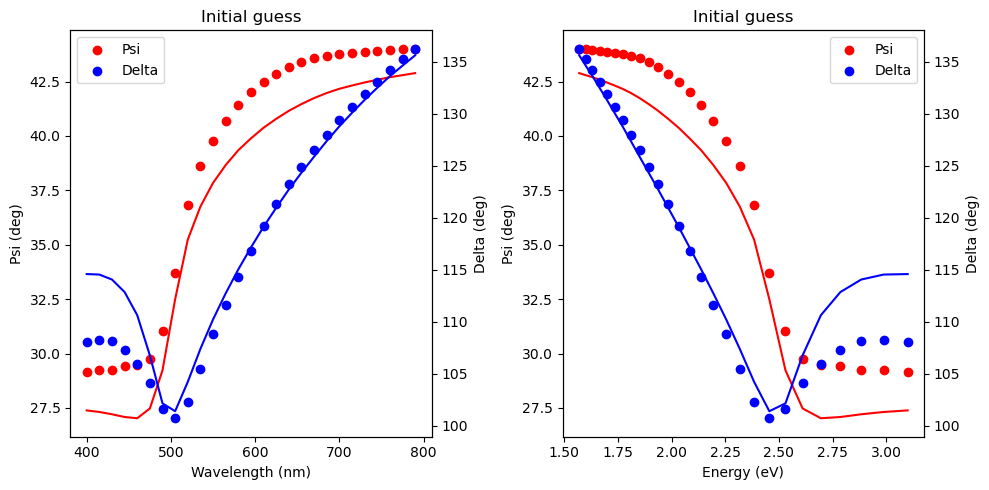

In [13]:
# Create a figure with 1 rows and 2 columns of subplots
fig, ax = plt.subplots(1,2,figsize=(10, 5))
axtlda = ax[0].twinx()
axteV = ax[1].twinx()

ax[0].plot(lda, psi, ls = '-', color = 'r',)
ax[1].plot(hw, psi, ls = '-', color = 'r',)
axtlda.plot(lda, delta, ls = '-', color = 'b',)
axteV.plot(hw, delta, ls = '-', color = 'b')

plda = ax[0].scatter(lda, d_psi, color="r", marker = 'o')
dlda = axtlda.scatter(lda, d_delta, color="b", marker = 'o')
peV = ax[1].scatter(hw, d_psi, color="r", marker = 'o')
deV = axteV.scatter(hw, d_delta, color="b", marker = 'o')

ax[0].legend(handles=[plda, dlda], labels=["Psi", "Delta"])
ax[1].legend(handles=[peV, deV], labels=["Psi", "Delta"])

ax[0].set(ylabel="Psi (deg)", xlabel="Wavelength (nm)", title="Initial guess")
ax[1].set(ylabel="Psi (deg)", xlabel="Energy (eV)", title="Initial guess")
axtlda.set(ylabel="Delta (deg)");
axteV.set(ylabel="Delta (deg)");

fig.tight_layout()

In [14]:
# ObjectiveSE function
# To retrieve fara from the model and the actual data

objective = ObjectiveSE(model, data)
objective.residuals()

array([-1.77927467, -1.94048456, -2.03104483, -2.34657304, -2.45617307,
       -2.26016193, -1.79694762, -1.21095984, -1.58130622, -1.86141514,
       -1.9144612 , -2.04113887, -2.09185566, -2.12770659, -2.09520933,
       -2.06308584, -2.01256962, -1.94780082, -1.8397482 , -1.71479076,
       -1.59520244, -1.50445125, -1.41440314, -1.32892464, -1.24610648,
       -1.18297372, -1.11736406,  6.50199042,  6.31852431,  5.91678693,
        5.61603808,  4.67480489,  2.64620727,  0.55487821,  0.67747842,
        1.90171412,  1.97145746,  1.40895047,  1.08614086,  0.75234091,
        0.30082795,  0.09911715,  0.39021561,  0.49884608,  0.5755605 ,
        0.62198192,  0.6081292 ,  0.58539077,  0.59399035,  0.57529801,
        0.57543497,  0.56547414,  0.61036229,  0.62238307])

### Fitting

In [15]:
fitter = CurveFitter(objective)
fitter.fit(method="least_squares");

Text(700, 29, 'Model with refined\nparameters')

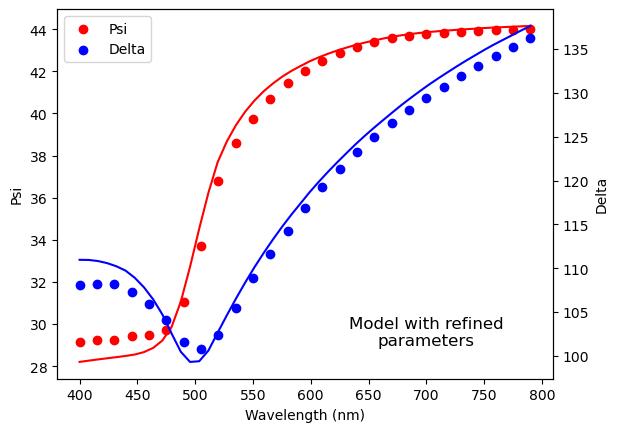

In [16]:
fig, ax = objective.plot()
ax.text(700, 29, "Model with refined\nparameters", ha="center", fontsize=12)

In [17]:
for i, x in enumerate(objective.model.parameters):
    print(x)

________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:'delta offset' , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0  (fixed) , bounds=[0.0, 1.0]>
________________________________________________________________________________
Parameters:      'Au'      
<Parameter: 'Au - thick'  , value=531.248 +/- 22.6 , bounds=[50.0, 1000.0]>
<Parameter: 'Au - rough'  , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:'Au - volfrac solvent', value=0  (fixed) , bounds=[0.0, 1.0]>
_________________________________________________________________

## Import raw data from a HORIBA file

Additionally to the modification in the `dataSE.open_HORIBAfile()` function described in [REFELLIPS_INSTALLATION.md](REFELLIPS_INSTALLATION.md). The encoding of the `.spe` file must be changed as well. **Both steps must be performed!**

To change the file encoding, the following bash script can be used:

``` bash
iconv -f WINDOWS-1252 -t UFT-8 file_name.spe > file_name-uft8.spe
```
Once this is performed, the analysis is performed as above

In [22]:
file = "Bk7Au-uft8.spe"
data = refellips.dataSE.open_HORIBAfile(file)

## Fitting data

*Spoiler:* Assuming flat gold thin film on glass substrate a thickness of (15.26 +/- 0.13) nm was obtained.

In [ ]:
glass = RI([1.5,0.])         # Constant refractive index $n$ with Re(n) = 1.5 and Im(n) = 0.0
gold = load_material("gold") #  Included experimental data of gold (au) in bulk. Probably Johnson & Christy data
air = RI([1.,0.])

glass.name = "Glass"
gold.name = "Au"
air.name = "Air"

# The thickness of layers are given in Angstroms. 
gold_layer = gold(350.)  # Estimated thickness of the sample (350 angstroms  = 35 nm)
gold_layer.thick.setp(vary=True, bounds=(50., 1000.)) # A flat surfaces is assumed. It is stated that the thickness can be varied and a ranged for it is defined

struc = air() | gold_layer | glass() # The structure of the system is defined with the refractive indices give at the begining.
                                     # The first (fronting/incidence) and last (backing/transmition) materials are assumed to
                                     # be infinite, thus no thickness is requiered. Any other materila is finite.

model = ReflectModelSE(struc) # Lastly the system can be modeled with the transfer matrix method

In [23]:
# Retrive the data from the CSV file
lda, aoi, d_psi, d_delta = data.data

# Calculate the ellipsometric parameters with the Transfere Matrix Method used in refellips
# The model is defined above as 
# model = ReflectModelSE(struc)
psi, delta = model(np.c_[np.ones_like(aoi) * lda, aoi])

hw = refellips.structureSE.nm_eV_conversion(lda)  # Photon energy for each wavelength

### First guess

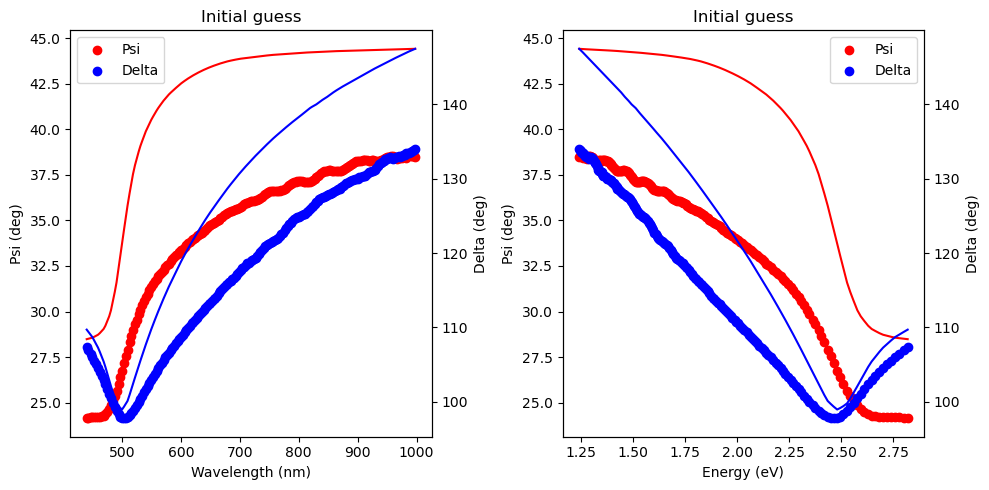

In [24]:
# Create a figure with 1 rows and 2 columns of subplots
fig, ax = plt.subplots(1,2,figsize=(10, 5))
axtlda = ax[0].twinx()
axteV = ax[1].twinx()

ax[0].plot(lda, psi, ls = '-', color = 'r',)
ax[1].plot(hw, psi, ls = '-', color = 'r',)
axtlda.plot(lda, delta, ls = '-', color = 'b',)
axteV.plot(hw, delta, ls = '-', color = 'b')

plda = ax[0].scatter(lda, d_psi, color="r", marker = 'o')
dlda = axtlda.scatter(lda, d_delta, color="b", marker = 'o')
peV = ax[1].scatter(hw, d_psi, color="r", marker = 'o')
deV = axteV.scatter(hw, d_delta, color="b", marker = 'o')

ax[0].legend(handles=[plda, dlda], labels=["Psi", "Delta"])
ax[1].legend(handles=[peV, deV], labels=["Psi", "Delta"])

ax[0].set(ylabel="Psi (deg)", xlabel="Wavelength (nm)", title="Initial guess")
ax[1].set(ylabel="Psi (deg)", xlabel="Energy (eV)", title="Initial guess")
axtlda.set(ylabel="Delta (deg)");
axteV.set(ylabel="Delta (deg)");

fig.tight_layout()

In [25]:
# ObjectiveSE function
# To retrieve fara from the model and the actual data

objective = ObjectiveSE(model, data)
objective.residuals()

array([ 5.94832084,  5.90229782,  5.87555323,  5.86179895,  5.82446769,
        5.89154269,  5.97659379,  5.91021407,  5.89509177,  5.97495481,
        5.95644298,  5.98730261,  5.98641345,  5.93419355,  5.91127676,
        5.82735234,  5.85814497,  5.88224024,  5.8733236 ,  5.90309475,
        5.9252297 ,  6.01835255,  6.04114694,  6.06518337,  6.13172394,
        6.11360031,  6.10646212,  6.07066736,  6.04895266,  6.04821512,
        6.05999199,  6.05515256,  6.04700198,  6.02365619,  6.01349966,
        6.04212576,  6.07154391,  6.06944537,  6.05132036,  6.079184  ,
        6.11161716,  6.16903048,  6.24498697,  6.29200809,  6.32802811,
        6.37570409,  6.44659036,  6.50639387,  6.55863084,  6.57037568,
        6.55606936,  6.60207497,  6.57861785,  6.56512945,  6.55669649,
        6.55350593,  6.51526596,  6.51325596,  6.53781891,  6.54279615,
        6.56223944,  6.61816457,  6.66196944,  6.75177524,  6.79326979,
        6.86376618,  6.96179184,  7.01822731,  7.07264872,  7.10

### Fitting

In [26]:
fitter = CurveFitter(objective)
fitter.fit(method="least_squares");

Text(700, 29, 'Model with refined\nparameters')

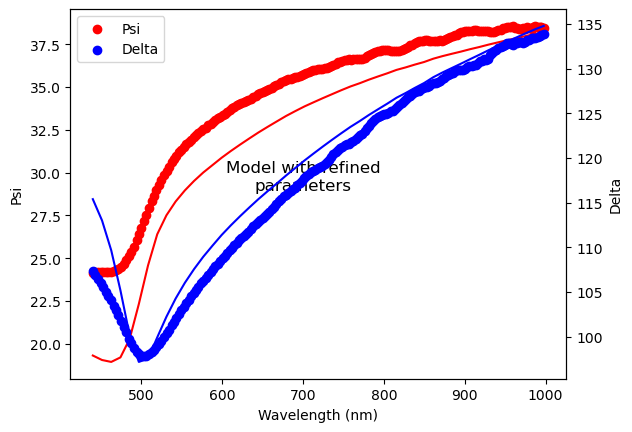

In [27]:
fig, ax = objective.plot()
ax.text(700, 29, "Model with refined\nparameters", ha="center", fontsize=12)

In [28]:
for i, x in enumerate(objective.model.parameters):
    print(x)

________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:'delta offset' , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0  (fixed) , bounds=[0.0, 1.0]>
________________________________________________________________________________
Parameters:      'Au'      
<Parameter: 'Au - thick'  , value=152.665 +/- 1.26 , bounds=[50.0, 1000.0]>
<Parameter: 'Au - rough'  , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:'Au - volfrac solvent', value=0  (fixed) , bounds=[0.0, 1.0]>
_________________________________________________________________